In [ ]:
import os

# Set your repo URL and folder name
repo_url = "https://github.com/bpleahey/thesis.git"
repo_dir = "thesis"
branch = "main"  # <-- your branch name

# Check if already inside the repo
cwd = os.getcwd()
if os.path.basename(cwd) == repo_dir:
    print(f"[INFO] Already inside '{repo_dir}' folder. Skipping clone.")
else:
    # Clone if not already in it
    if not os.path.exists(repo_dir):
        # clone and checkout correct branch
        !git clone --branch {branch} {repo_url}
    else:
        print(f"[INFO] '{repo_dir}' already exists. Skipping clone.")

    # Move into the repo
    %cd {repo_dir}

    # Make sure we are on the correct branch
    !git checkout {branch}

# Install requirements (you may have to restart the session)
!pip install -r requirements.txt

In [ ]:
import os
from IPython import get_ipython

# Get current working directory
cwd = os.getcwd()

# Check if we're inside 'thesis' folder
if os.path.basename(cwd) == 'thesis':
    print("[INFO] Inside 'thesis/' — moving up one level.")
    get_ipython().run_line_magic('cd', '..')
else:
    print(f"[INFO] Current directory is '{os.path.basename(cwd)}' — no need to move.")

In [ ]:
%ls

In [ ]:
# Download test dataset

!pip install gdown
!gdown 'https://drive.google.com/uc?id=1SP1OPm2jBCzHG3gPuE4rGo_BGrrizA6O'

In [ ]:
# unzip test set

!unzip test_ablation.zip -d test

In [ ]:
# clear MACOS files

!rm -rf test/__MACOSX/

In [ ]:
# if data downloads incorrectly/is corrupted, use this to delete it

!rm -rf '/content/test'
# !rm -rf '/content/106m (350ft)'
# !rm -rf '/content/121m (400ft)'
# !rm -rf '/content/15m (50ft)'
# !rm -rf '/content/30m (100ft)'
# !rm -rf '/content/45m (150ft)'
# !rm -rf '/content/61m (200ft)'
# !rm -rf '/content/76m (250ft)'
# !rm -rf '/content/91m (300ft)'

In [ ]:
%ls

In [ ]:
# basic preprocessing/cropping

import os
import cv2
import glob
import numpy as np
from tqdm import tqdm  # progress bar

dataset_path = 'test/test_ablation/'
image_files = glob.glob(os.path.join(dataset_path, '**', '*.jpg'), recursive=True)

CROP = 100  # pixels to crop from each side

for image_file in tqdm(image_files, desc="Processing images"):
    image = cv2.imread(image_file)

    if image is None:
        print(f"Error loading image: {image_file}")
        continue

    height, width = image.shape[:2]
    label_file = os.path.splitext(image_file)[0] + '.txt'

    # Crop 'dronevehicle' images with sufficient size
    if 'dronevehicle' in image_file and height > 640 and width > 512:
        # Compute new size
        new_w = width - 2 * CROP
        new_h = height - 2 * CROP

        # Adjust labels
        if os.path.exists(label_file):
            new_lines = []
            with open(label_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue  # skip malformed lines
                    cls, x, y, w, h = map(float, parts)

                    # Convert normalized to absolute
                    abs_x = x * width
                    abs_y = y * height
                    abs_w = w * width
                    abs_h = h * height

                    # Adjust center for crop
                    abs_x -= CROP
                    abs_y -= CROP

                    # Check if center is still inside the new image
                    if abs_x < 0 or abs_x >= new_w or abs_y < 0 or abs_y >= new_h:
                        continue

                    # Normalize to new size
                    new_x = abs_x / new_w
                    new_y = abs_y / new_h
                    new_w_norm = abs_w / new_w
                    new_h_norm = abs_h / new_h

                    new_lines.append(f"{int(cls)} {new_x:.6f} {new_y:.6f} {new_w_norm:.6f} {new_h_norm:.6f}\n")

            # Overwrite with updated labels
            with open(label_file, 'w') as f:
                f.writelines(new_lines)

        # Crop and save image
        cropped_image = image[CROP:-CROP, CROP:-CROP]
        cv2.imwrite(image_file, cropped_image)
        image = cropped_image  # update for potential grayscale conversion

    # Process IR/TIR images
    if ('tir' in image_file.lower()) or ('ir' in image_file.lower()):
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_img = cv2.normalize(gray_image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        equalized = clahe.apply(norm_img)
        cv2.imwrite(image_file, equalized)

Processing images: 100%|██████████| 400/400 [00:02<00:00, 133.74it/s]


In [ ]:
import re

def extract_drive_id(url):
    match = re.search(r"/d/([a-zA-Z0-9_-]+)", url)
    if match:
        return match.group(1)
    else:
        raise ValueError("Invalid Google Drive URL format")

In [ ]:
# download previous runs

%cd /content/

# weights:
# Folder of runs: https://drive.google.com/drive/folders/1Hike1cY2mF2tC7Wl7zxgiahxMxVL3sXB?usp=drive_link

file_id = extract_drive_id('https://drive.google.com/file/d/1hHdmwIXSJkSUXV9OObJdWCgNXDP-DRqL/view?usp=drive_link')

!gdown --id {file_id}

#for late fusion, extract an ir file
ir_file_id = extract_drive_id('https://drive.google.com/file/d/14-cHgm_WLOxUoG0KoYj7BQ2QONWB-ugg/view?usp=drive_link')
if ir_file_id:
  !gdown --id {ir_file_id}

In [ ]:
# extract weights from runs files

filename = 'RGB_fusion_branch'
ir_filename = 'IR_fusion_branch' #for late fusion, comment out for other approaches

!rm -rf runs/
!unzip {filename} -d runs
!rm -rf {filename}

import shutil
import os

!rm -rf thesis/best.pt

# # Define source and destination paths
src_path = "runs/weights/best.pt"
dst_path = "best.pt"
shutil.move(src_path, dst_path)
shutil.rmtree("runs")

if(ir_filename):
  !unzip {ir_filename} -d runs
  !rm -rf {filename}
  dst_path = "best_ir.pt"
  shutil.move(src_path, dst_path)
  shutil.rmtree("runs")

In [ ]:
# remove previous runs if desired

%cd thesis/
!rm -rf runs/test/*

[Errno 2] No such file or directory: 'thesis/'
/content/thesis


In [ ]:
%cd ..

/content


In [ ]:
# removed cached indices breaking dataloader
#!find content/                                        test/ -name "*.cache" -exec rm {} \;
!find ../ -name "*.cache" -exec rm {} \;

In [ ]:
%cd thesis/
!python test.py --img 640 \
    --batch 16 \
    --data eval_ablation.yaml \
    --device 0 \
    --weights best.pt \
    --conf 0.01 \
    --iou 0.65 \
    --name late_fusion_NMS_AVG_weighted_61 \
    --ir-weights best_ir.pt \
    --late-fusion-method AVG+Weight

# !python test.py --img 640 \
#     --batch 16 \
#     --data eval_rgb.yaml \
#     --device 0 \
#     --weights best.pt \
#     --conf 0.01 \
#     --iou 0.65 \
#     --name output_test

In [ ]:
from google.colab import files
import shutil

shutil.make_archive('late_fusion_AVG', 'zip', 'runs/test/')
files.download('late_fusion_AVG.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

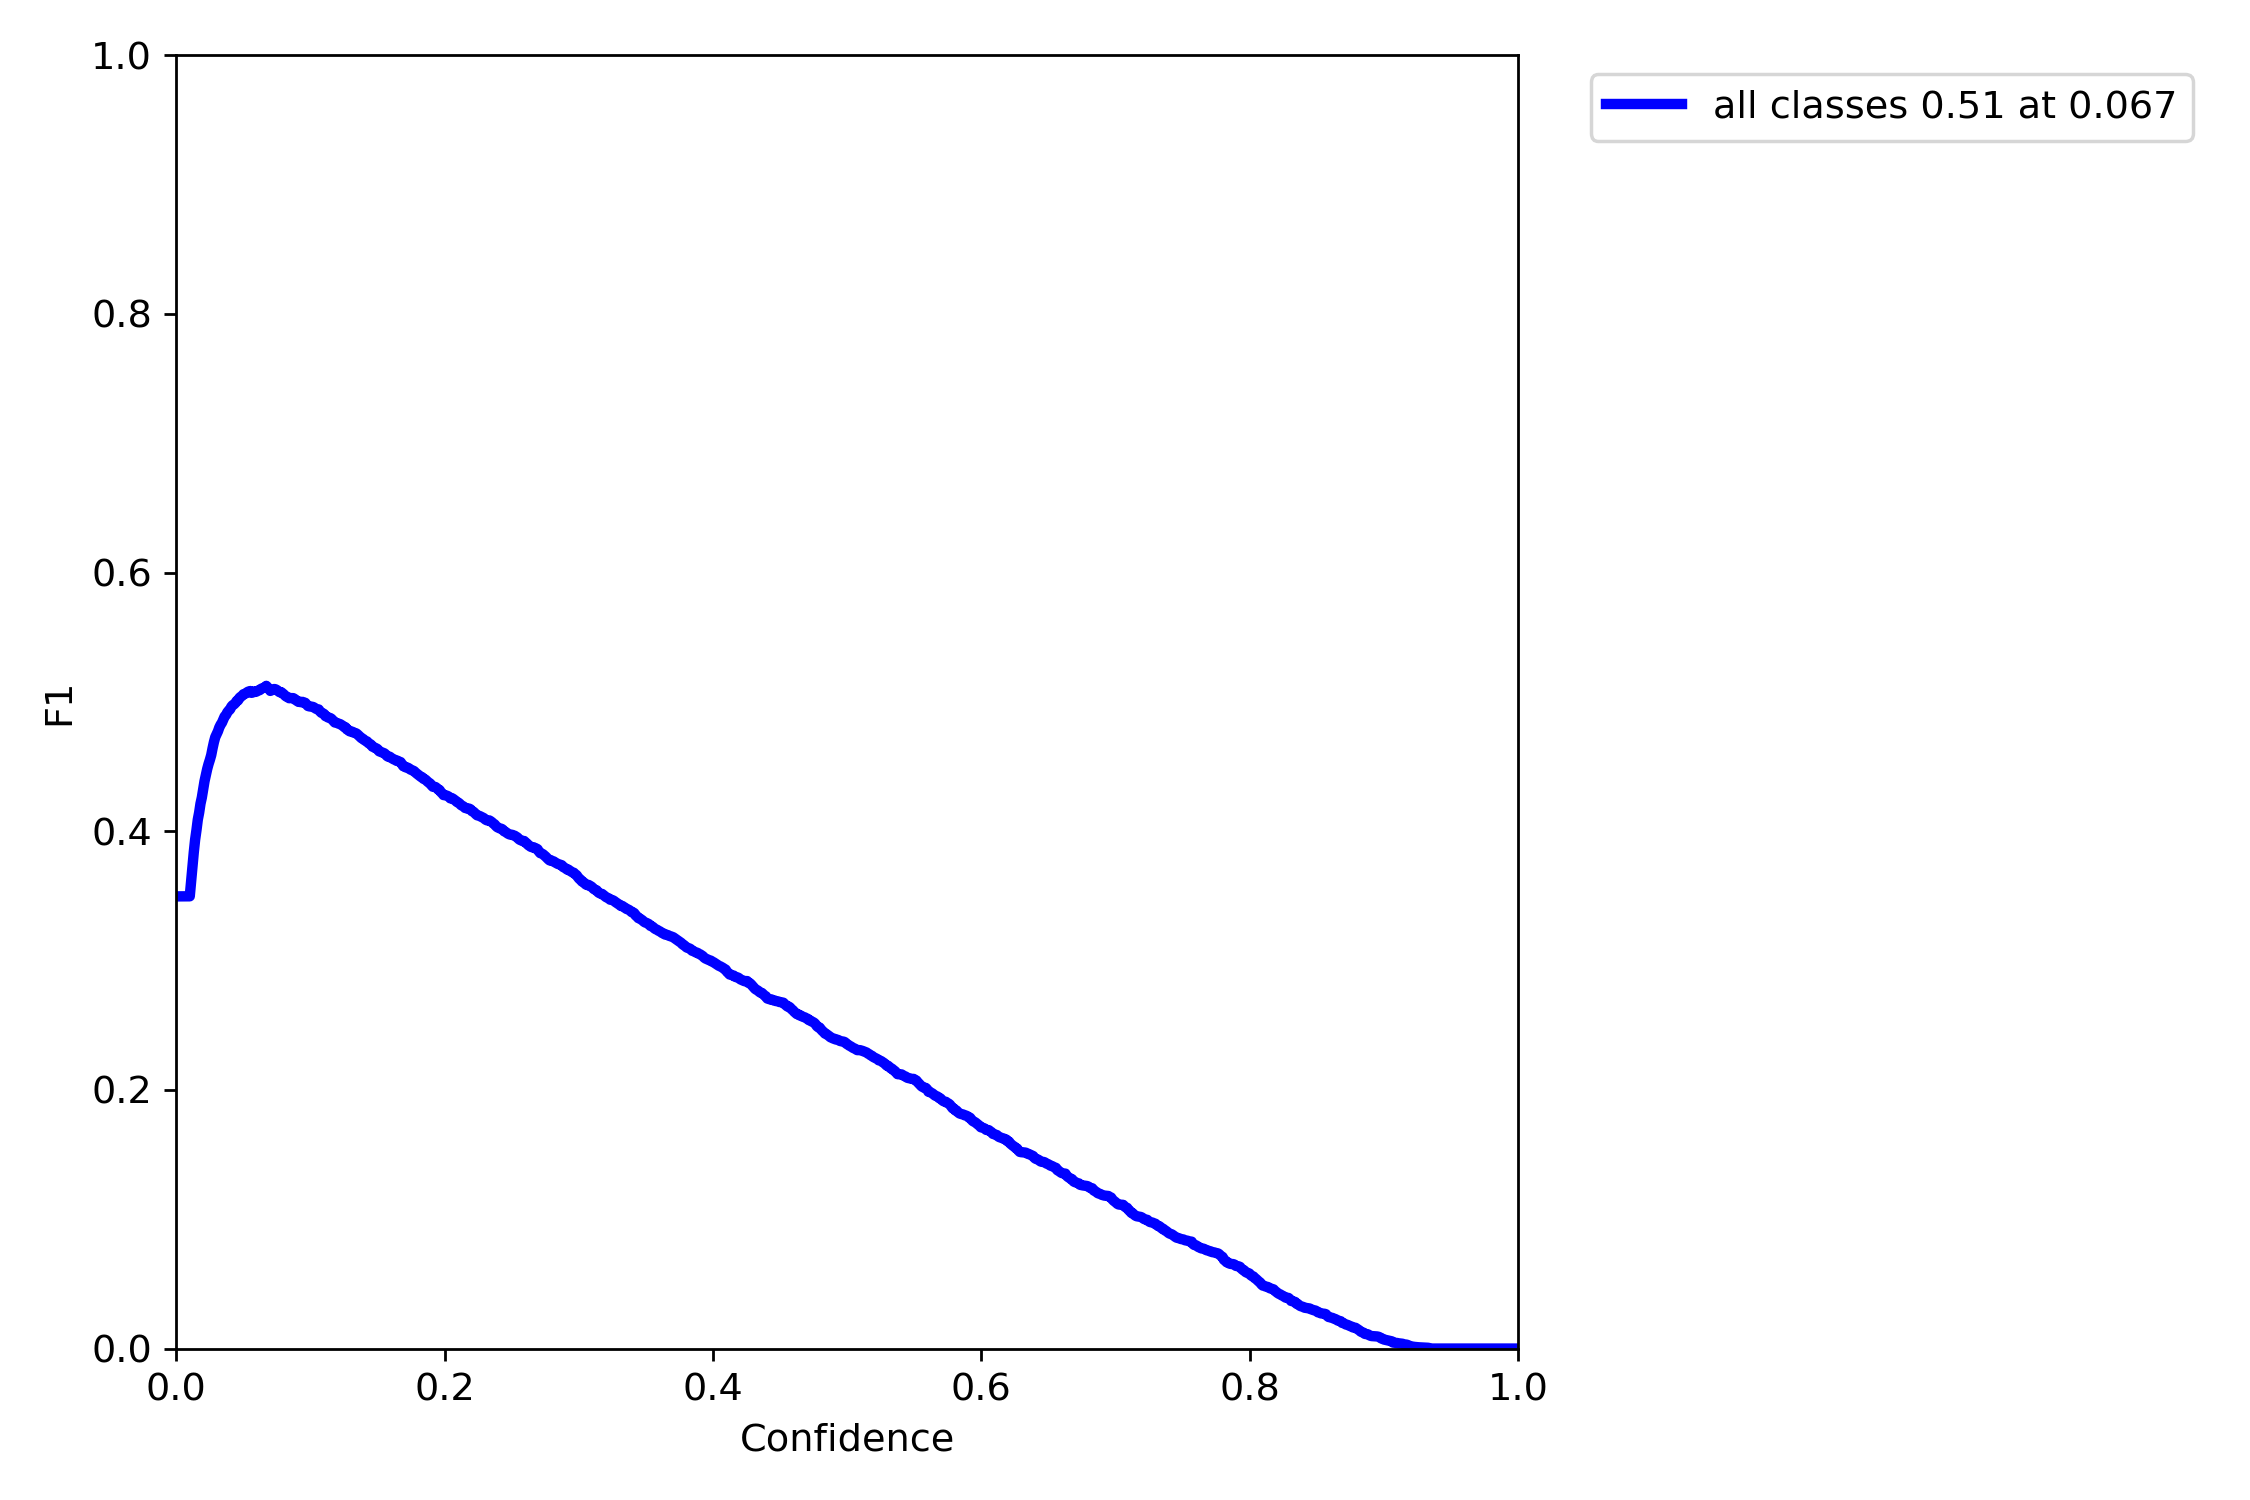

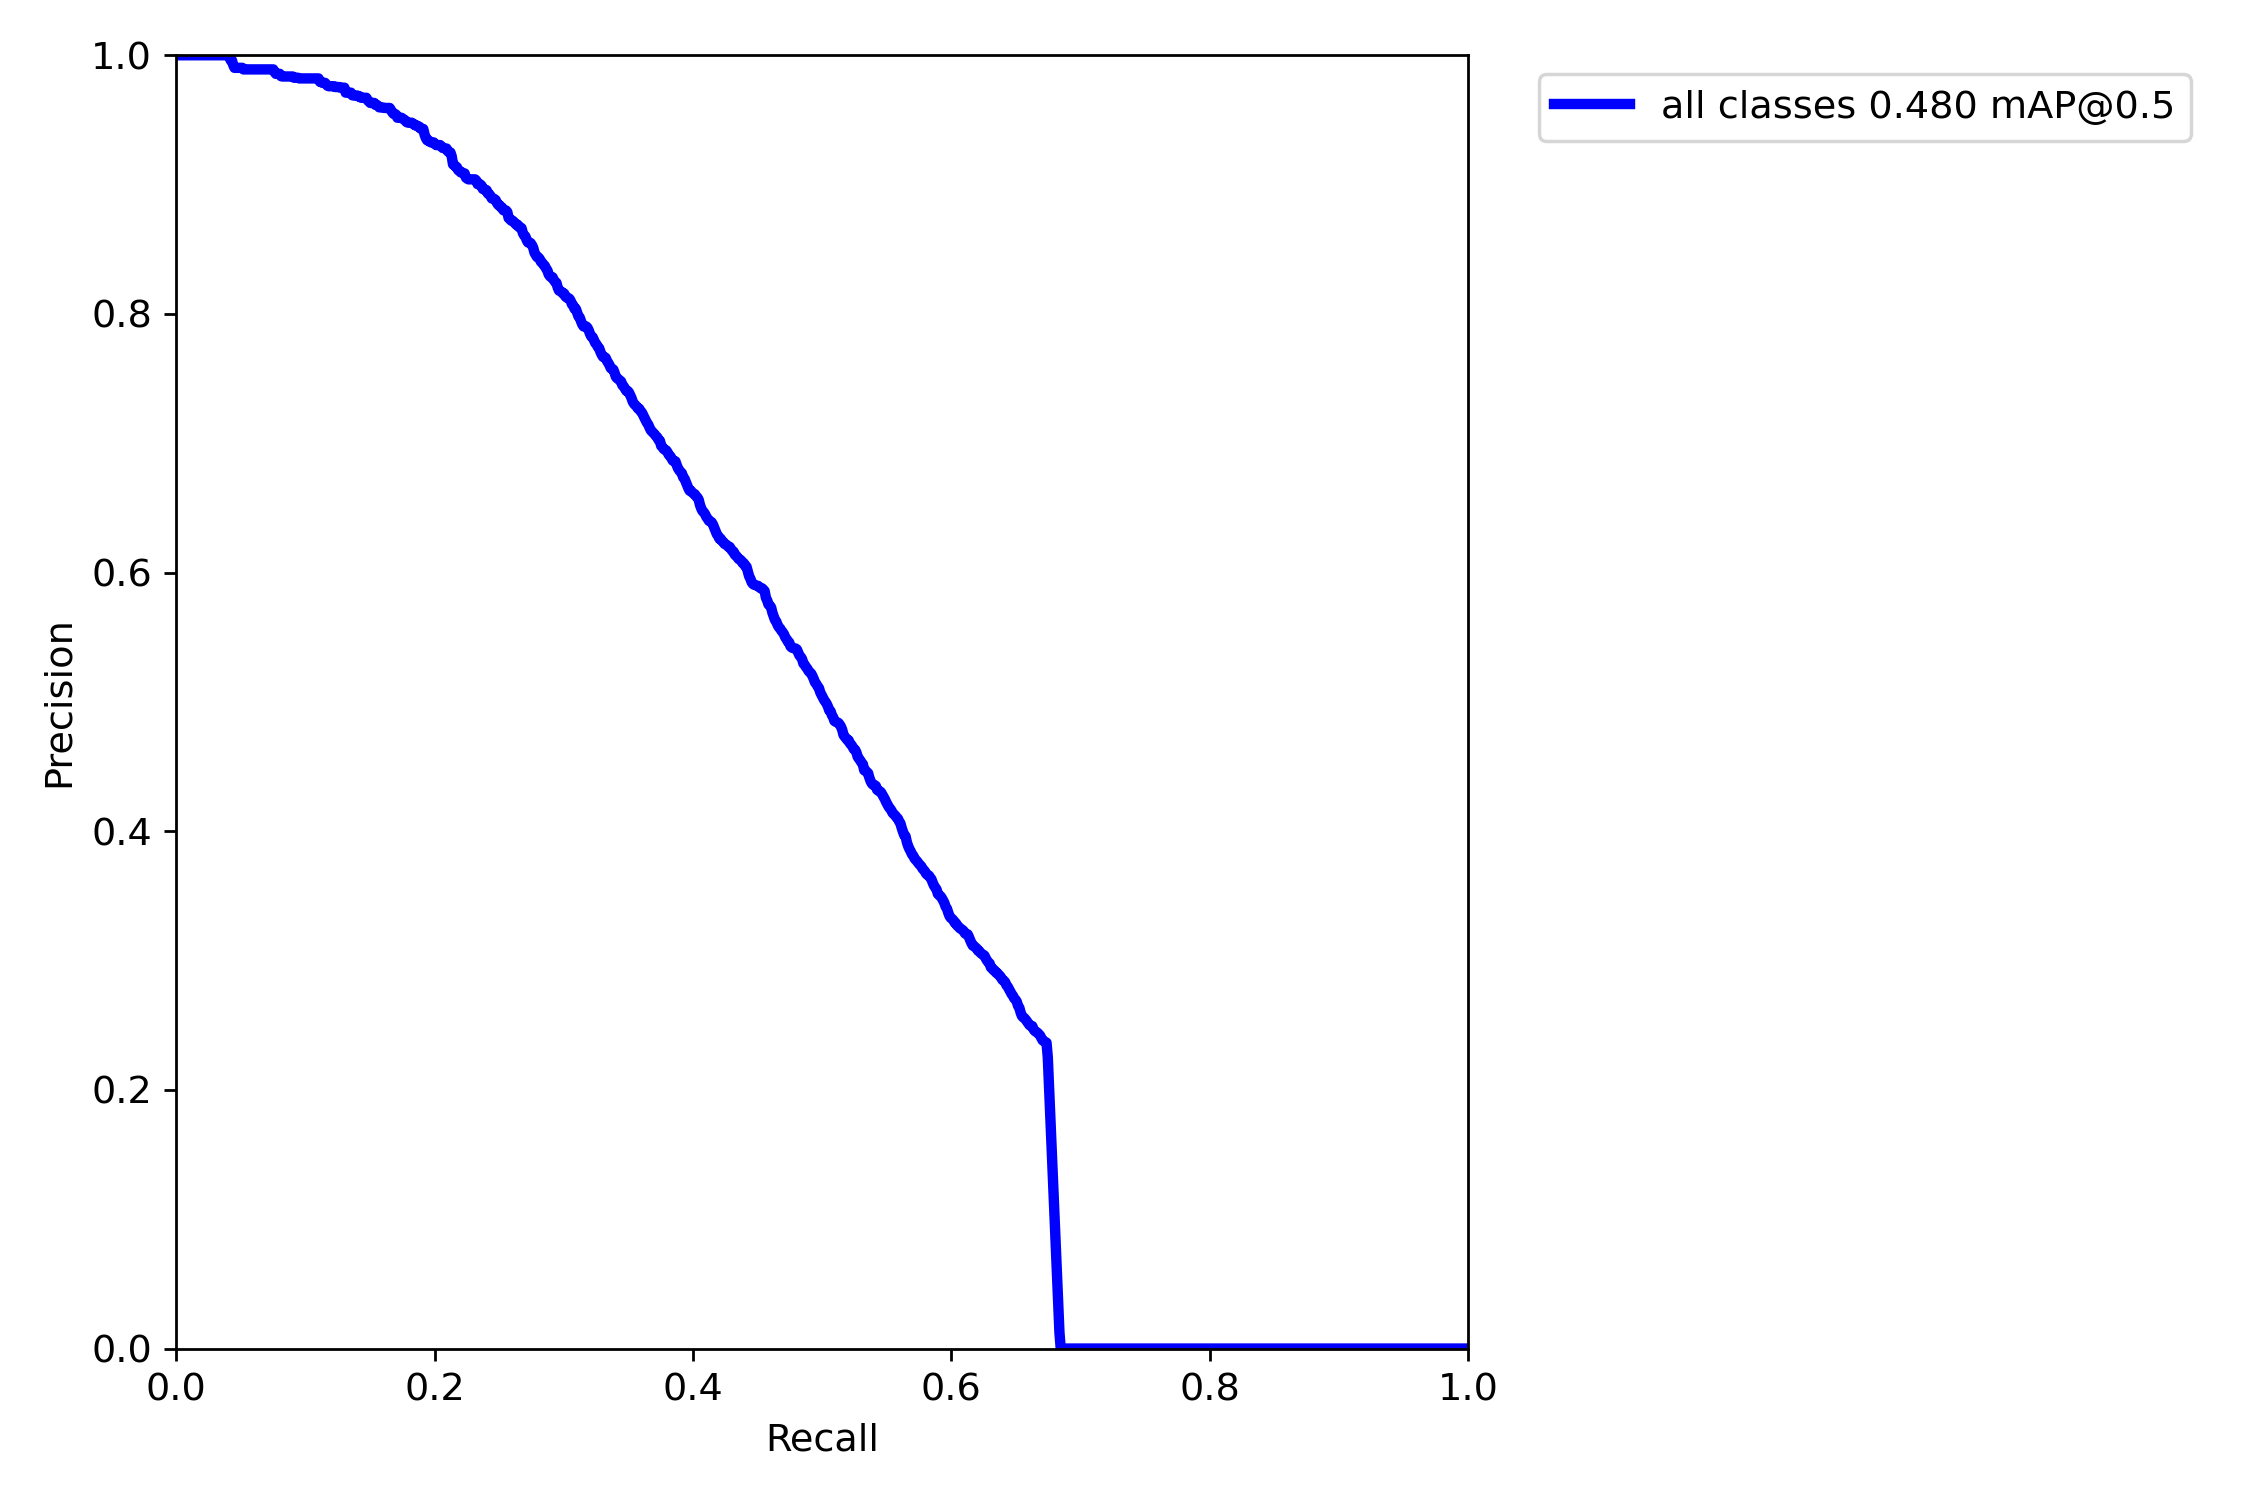

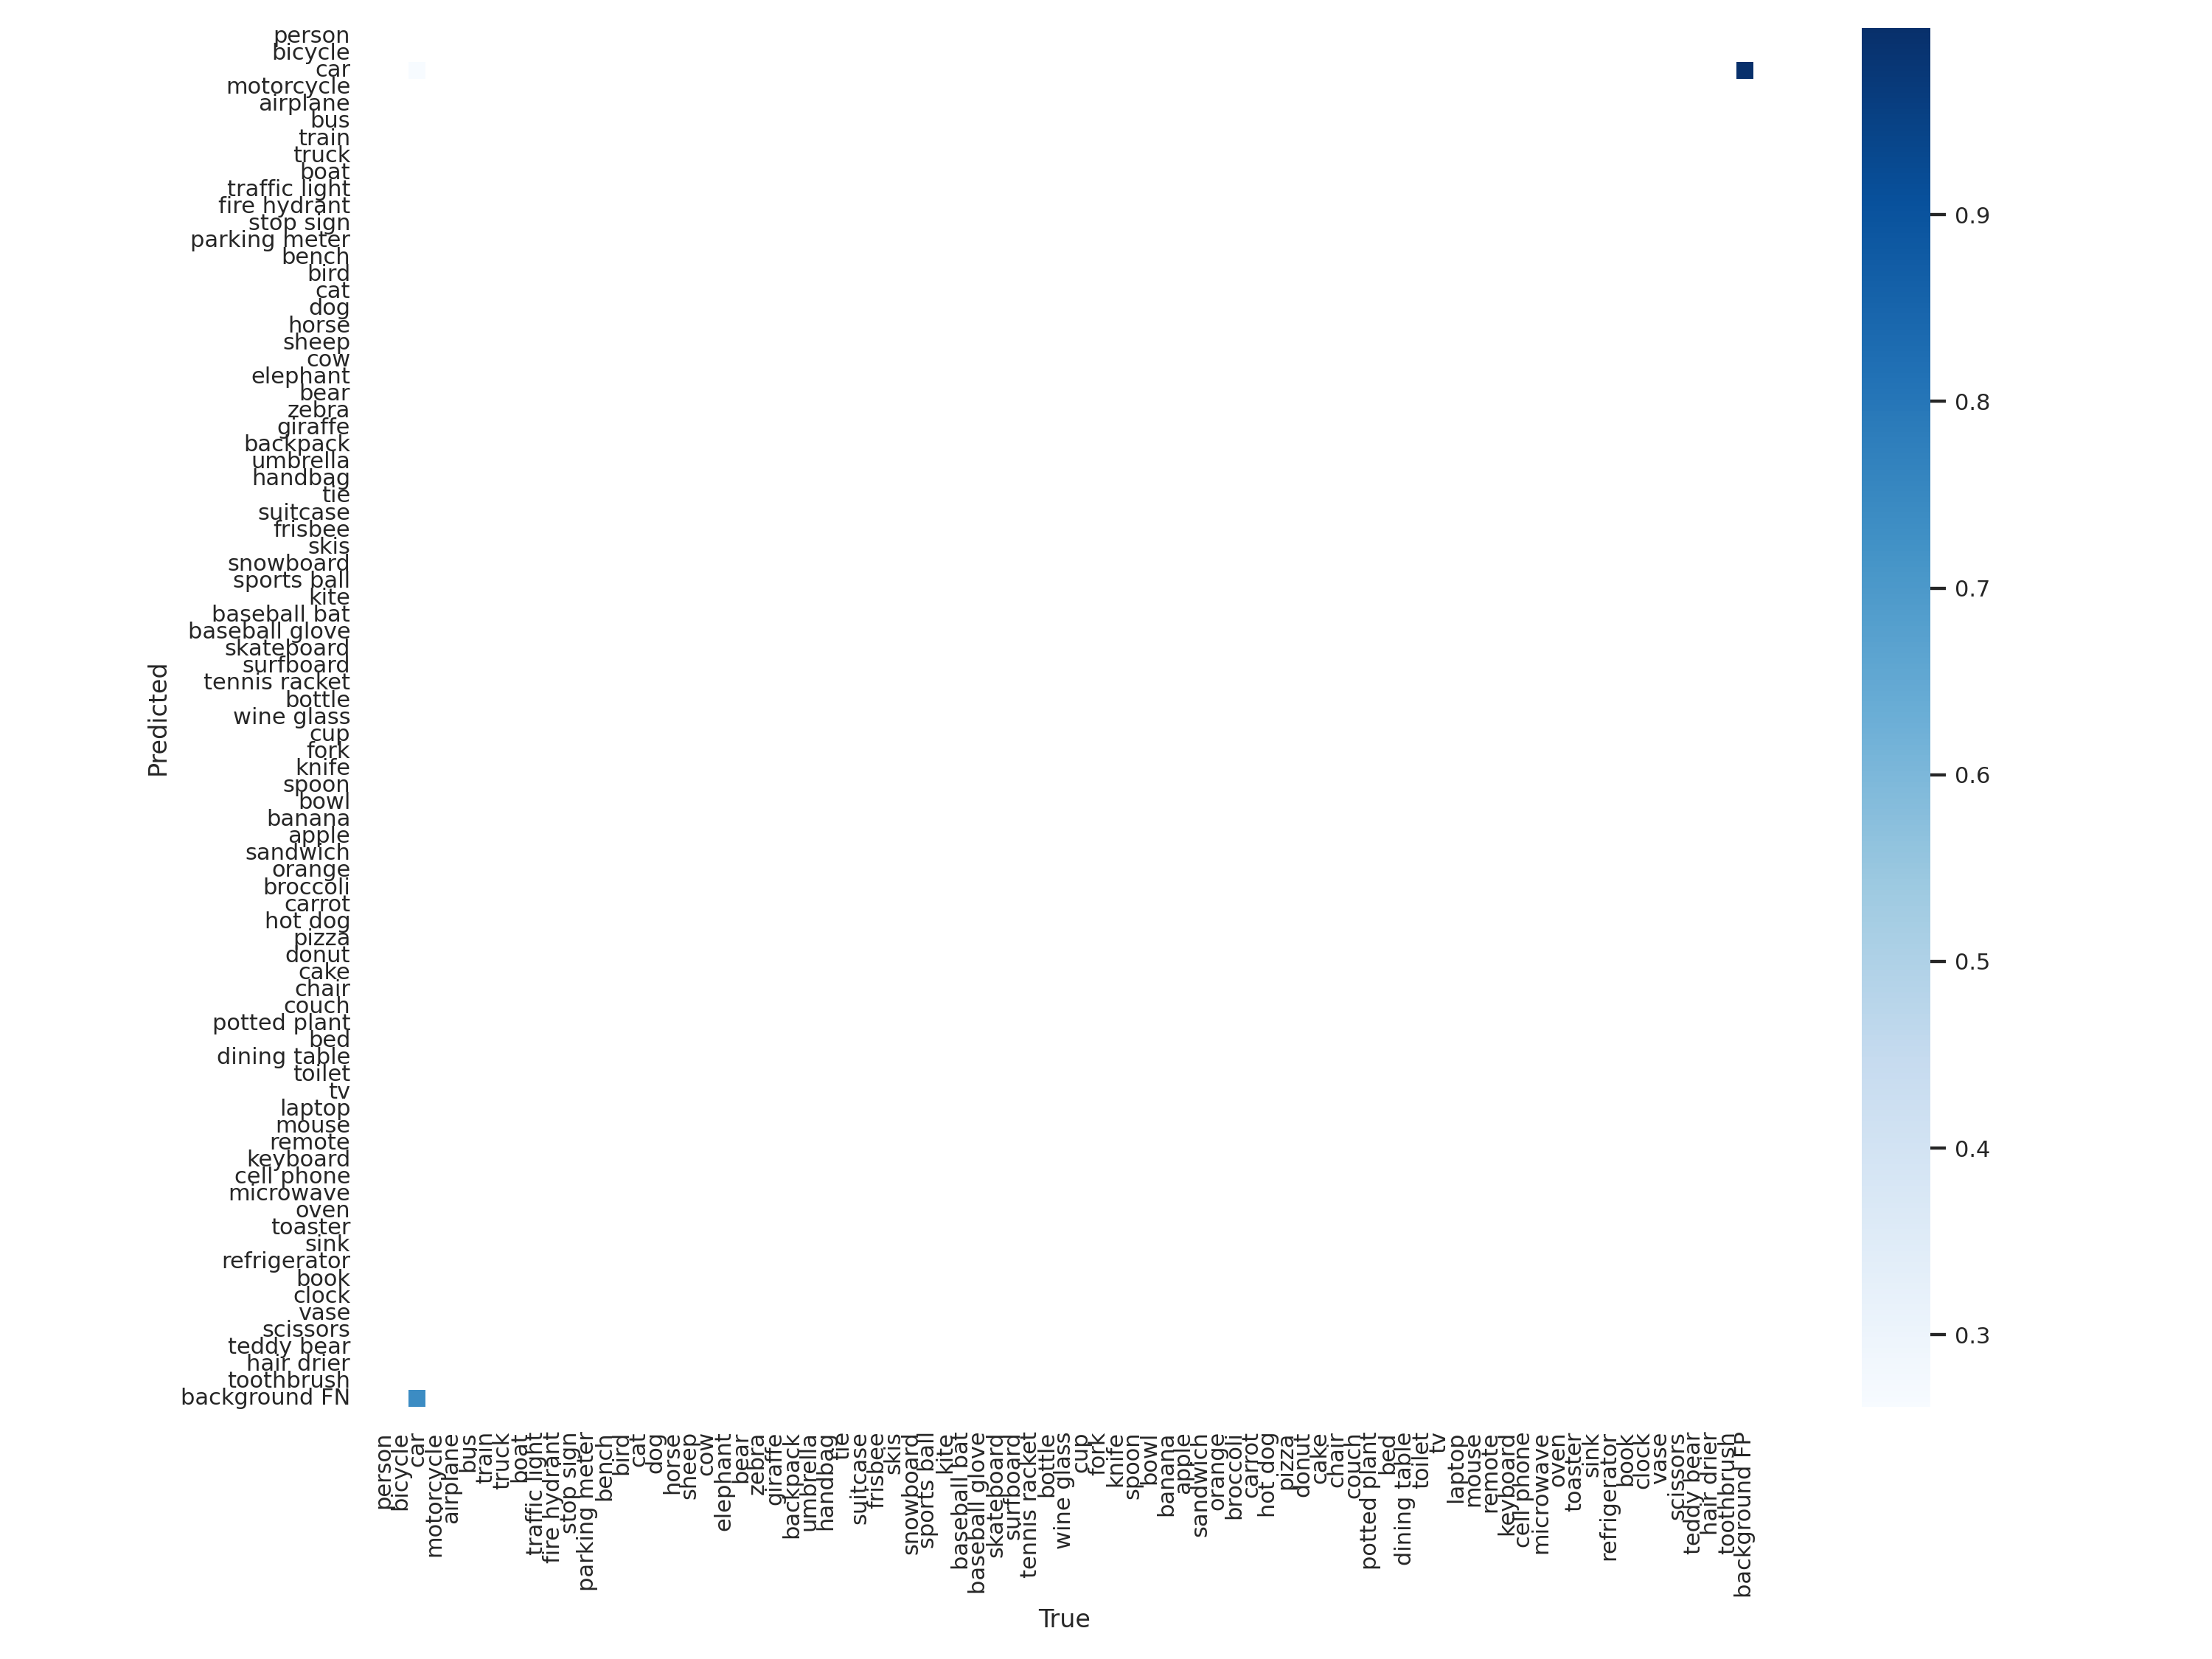

In [ ]:
from IPython.display import Image

# Untrained rgb Results
display(Image("runs/test/rgb/F1_curve.png", width=400, height=400))
display(Image("runs/test/rgb/PR_curve.png", width=400, height=400))
display(Image("runs/test/rgb/confusion_matrix.png", width=500, height=500))

In [ ]:
!python detect.py --weights yolov7-tiny.pt --conf 0.1 --img-size 640 --source test/

In [ ]:
# correct paths for your own run
from IPython.display import Image
display(Image("runs/test/exp4/F1_curve.png", width=400, height=400)) # correct path
display(Image("runs/test/exp4/PR_curve.png", width=400, height=400))
display(Image("/content/gdrive/MyDrive/yolov7/runs/train/exp4/confusion_matrix.png", width=500, height=500))

In [ ]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

i = 0
limit = 10000 # max images to print
for imageName in glob.glob('/content/gdrive/MyDrive/yolov7/runs/detect/exp2/*.jpg'):
    #Assuming JPG
    if i < limit:
      display(Image(filename=imageName))
      print("\n")
    i = i + 1

display(Image("/content/gdrive/MyDrive/yolov7/military_vics_test/", width=400, height=400))
